### This script compares SDA spectrum between theory and simulation

In [1]:
%run LoadNotebook
import SDA 
import warnings
import numpy as np
%matplotlib inline
import DataProcess as R
import INITMAXWELL
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from scipy import integrate

importing Jupyter notebook from SDA.ipynb
importing Jupyter notebook from DataProcess.ipynb
importing Jupyter notebook from INITMAXWELL.ipynb
beta_s 0.497437272239
beta_s 0.308786016004
beta_s 0.245334714929


In [2]:
# Simulation file directory
dpath1 = '/tigress/ruix/new_simu/1dang63mass100_up/output/'
dpath2 = '/tigress/ruix/new_simu/2dang63mass100_up/output/'
path_list = [dpath1,dpath2]

('time/t0=', 1.0)
('time/t0=', 0.083333328)


[0.001, 200.0, 1e-05, 0.1]

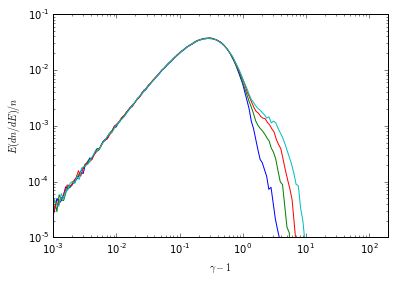

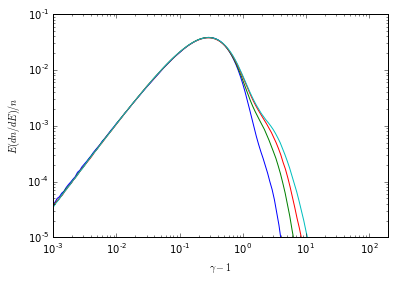

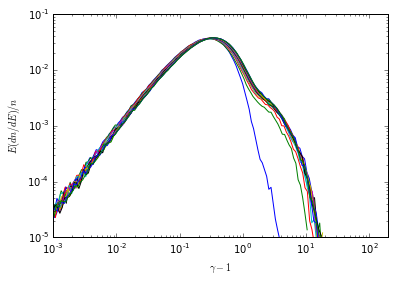

In [15]:
'''
Evolution of upstream spectrum (comparison between 1d & 2d)
'''
num = 4
interval = 1
ind_start = 2
Time0 = R.readparam(dpath1,'time',1)
for dpath in path_list:
    fig = plt.figure()
    NT0 = R.readparam(dpath,'time',1)/Time0  
    print  ('time/t0=',NT0)

    for i in range(num):
        ind = int((i*interval+2)/NT0)
        # Simulation spectrum
        mom,gamma,momedist,mompdist,edist,pdist = R.spect1d(dpath,ind,xL=500,xR=1000,shock=1,frame='')
        plt.loglog(gamma,edist,lw=1)

    plt.ylabel('$E(dn/dE)/n$')
    plt.xlabel('$\gamma-1$')
    plt.axis([1e-3,2e2,1e-5,1e-1])

'''
Long-term 1d simulation upstream spectrum
'''
fig = plt.figure()
num = 16
interval = 5
ind_start = 2
for i in range(num):
    ind = (i*interval+2)
    mom,gamma,momedist,mompdist,edist,pdist = R.spect1d(dpath1,ind,xL=500,xR=1000,shock=1,frame='')
    plt.loglog(gamma,edist,lw=1)

plt.ylabel('$E(dn/dE)/n$')
plt.xlabel('$\gamma-1$')
plt.axis([1e-3,2e2,1e-5,1e-1])

[0.001, 100.0, 0.0001, 0.1]

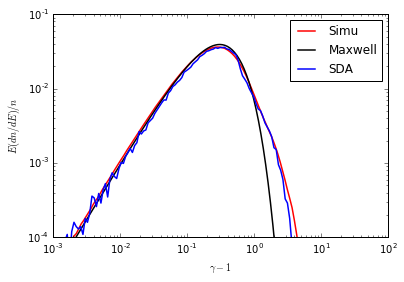

In [4]:
'''
Spectrum from simulation and SDA theory
'''
ind   = 20
DelGam = 0.17

# Simulation spectrum
mom,gamma,momedist,mompdist,edist,pdist = R.spect1d(dpath2,ind,xL=100,xR=500,shock=1,frame='')
plt.loglog(gamma,edist,c='r',lw=1.5,label='Simu')

# Maxwellian spectrum
mom,femom = R.SetT(dpath,mass=1, DelGam=DelGam, ind=ind, spect_type='energy',rangex=-3,rangey=3,num=200)
plt.loglog(mom,femom/12,c='k',lw=1.5,label='Maxwell')

# Synthetic Spectrum
prtl_num = 100000
pdf_sz   = 1000
vsh_up   = 0.22
btheta   = 63.*np.pi/180.
ePhi     = 0.6
r        = 3
gamma_list, fe, fsda = SDA.rel_sda_spectrum(prtl_num,DelGam,pdf_sz,vsh_up,btheta,ePhi,r)
plt.loglog(gamma_list,fsda,c='b',lw=1.5,label='SDA')

plt.legend()
plt.ylabel('$E(dn/dE)/n$')
plt.xlabel('$\gamma-1$')
plt.axis([1e-3,1e2,1e-4,1e-1])

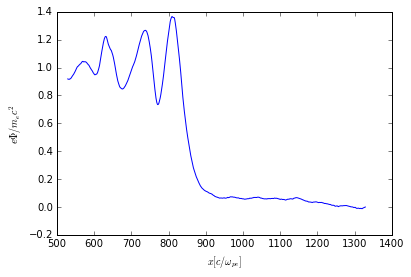

In [5]:
'''
Cross field potential as a function of x-axis
'''
ind = 63
xL  =-300
xR  = 500
param = 'ex'
pval   = R.readflds(dpath2,param,ind)
pfield = pval[pval.shape[0]/2,:]/R.readparam(dpath2,'b0',ind)
pval   = pval[3:pval.shape[0]-2,:]
if pval.shape[0]>10:
    pfield = np.mean(pval,axis=0)/R.readparam(dpath2,'b0',ind)
xval  = np.linspace(0,pval.shape[1]/R.readparam(dpath2,'c_omp')*R.readparam(dpath2,'istep'),pval.shape[1])
ishf,xshf,_= R.shfind(dpath2,ind)
in_range = (xval>=xshf+xL) & (xval<=xshf+xR) 
    
pfield = pfield[in_range]
xval  = xval[in_range]
    
int_potential = integrate.cumtrapz(pfield[::-1], xval[::-1], initial=0)
Poten_reverse = -int_potential*R.cal_param(dpath,'Va')*np.sqrt(R.readparam(dpath2,'mi')/R.readparam(dpath2,'me'))
Poten = Poten_reverse[::-1]
plt.plot(xval,Poten)
plt.xlabel('$x[c/\omega_{pe}]$')
plt.ylabel('$e\Phi/m_e c^2$')

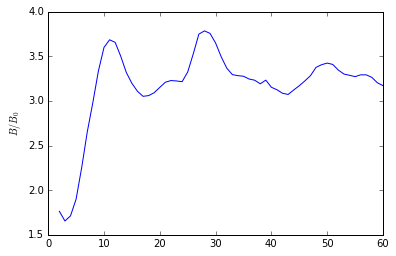

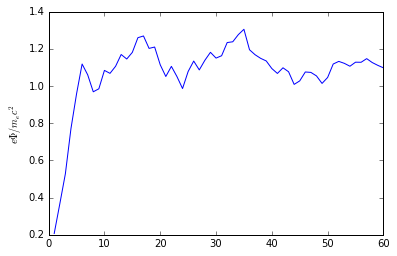

In [6]:
'''
Calculate key SDA parameters from 2d simulation
'''
num = 60
xL  = -50
xR  = 200
param ='ex'
fldsratio = np.empty(num)
potential = np.empty(num)
x = np.linspace(1,num,num)
for ind in range(num):
    fldsratio[ind] = R.fldsratio(dpath2,ind+1,xL,xR)
    potential[ind] = R.cross_field_potential(dpath2,ind+1,param,xL,xR)

plt.plot(x,fldsratio)
plt.ylabel('$B/B_0$')
fig=plt.figure()
plt.plot(x,potential)
plt.ylabel('$e\Phi/m_e c^2$')

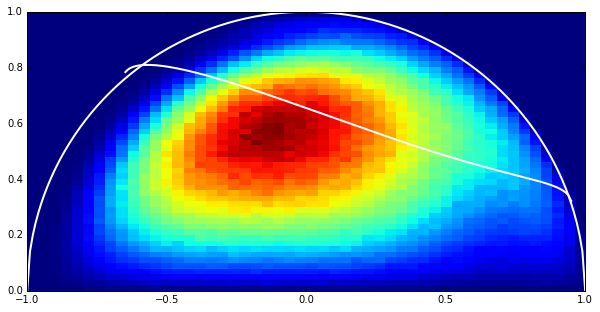

In [12]:
'''
Particle distribution in the simulation
'''
ind = 60
# particles ahead of shock
vpa0,vpr0 = SDA.phase_dist(dpath2,ind,xL=0,xR=500,BetaBoost=0)
gam0 = 1./np.sqrt(1-vpa0**2-vpr0**2)
nonth_ind = gam0>0.
# generate the same number of Maxwellian particles
#gamm,vpam,vprm = INITMAXWELL.generate_maxwell_dist(len(vpa0),delgam=0.17,pdf_sz=1000,btheta=70*np.pi/180.,outform='polar')
#Hm,xedges,yedges = np.histogram2d(vprm, vpam, bins= 50,range=[[0,1], [-1,1]])
H0,xedges,yedges = np.histogram2d(vpr0[nonth_ind], vpa0[nonth_ind], bins= 50,range=[[0,1], [-1,1]])
plt.figure(figsize=(10,5))
im = plt.imshow(H0, interpolation='nearest', origin='low', extent=[yedges[0],yedges[-1],xedges[0],xedges[-1]])

# calculate compression ratio and cross field potential
r = 4
ePhi = 0.5
# SDA curve
bpara_num = 200
bpara_crit, bperp_crit = SDA.SDA_reflection_curve(vsh_up,btheta, ePhi, r, bpara_num)
plt.plot(bpara_crit,bperp_crit,c='w',lw=2)
x1 = np.linspace(-1,1,200)
y1 = np.sqrt(1-x1**2)
plt.plot(x1,y1,lw=2,c='w')
#vpa1,vpr1,gam1,frac = SDA.Prtl_SDA_reflection(vsh_up, btheta, bpara_crit,bperp_crit,
# vpa0[nonth_ind],vpr0[nonth_ind],gam0[nonth_ind])
#print frac       